# Preparation

## Directory and imports

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training

## Imports

In [22]:
from DataLoader import GamesMemoryBank
from policy_loss import PolicyLoss
from Model import PolicyNetwork, NET_INPUT_SIZE
from simulation_two_qubits import QuantumEnvironment

import torch
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from os.path import isfile
from scipy.ndimage import uniform_filter1d

plt.style.use({'figure.facecolor':'white'})

## Initialization

### Constants

In [23]:
n_epochs = 50
games_per_epoch = 20
batch_size = 30000
num_batches = 5
learning_rate = 1e-3

### Classes

In [24]:
run_time = 2
dt = 0.05
decay_rate = 0.96

env = QuantumEnvironment(energy_gap=1, runtime=run_time, dt=dt)


loss_func = PolicyLoss()
net = PolicyNetwork()

model_name = 'trained_model.pt'
# If such a previous model exists
# if isfile(model_name):
#     net.load_state_dict(torch.load(model_name))

memory_bank = GamesMemoryBank()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

## Training loop

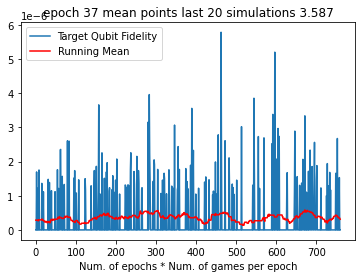

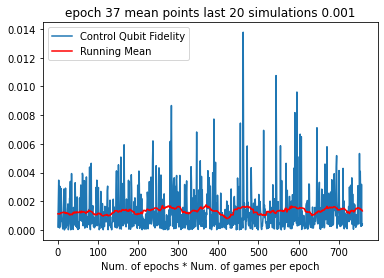

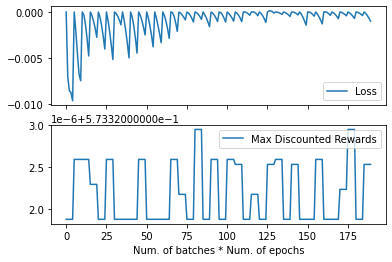

 76%|███████▌  | 38/50 [08:19<02:37, 13.16s/it]


KeyboardInterrupt: 

In [25]:
final_fidelity_target = []
final_fidelity_control = []
losses = []
rewards = []
discounted_rewards = []
running_time = []

for epoch in tqdm(range(n_epochs)):
    
    memory_bank.clear_memory()
    
    net.eval()
    net.cpu()
    
    for game_i in range(games_per_epoch):

        state, prev_state = env.reset(), None

        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        prev_state = torch.zeros_like(state)

        while True:
            with torch.no_grad():
                action, action_p = net.sample_action(state, prev_state)
            new_state, reward, done, info = env.step(action)
            memory_bank.add_event(state, prev_state, action, action_p, reward)
            
            prev_state = state
            state = torch.tensor(new_state, dtype=torch.float).view(-1).unsqueeze(0)

            if done:
                final_fidelity_target.append(env.fidelity())
                final_fidelity_control.append(env.fidelity(label='control'))
                # running_time.append(env.steps*dt/run_time)
                break

    memory_bank.compute_reward_history()
    
    clear_output(wait=True)
    mean_fid_target = np.mean(final_fidelity_target[-games_per_epoch:])
    running_mean_fid_target = uniform_filter1d(final_fidelity_target,50)
    mean_fid_target = str(mean_fid_target)[:5]
    plt.title('epoch ' + str(epoch) 
                       + ' mean points last ' 
                       + str(games_per_epoch) 
                       + ' simulations '
                       + mean_fid_target)
    plt.plot(final_fidelity_target, label='Target Qubit Fidelity')
    plt.plot(running_mean_fid_target, label='Running Mean', color='red')
    plt.xlabel('Num. of epochs * Num. of games per epoch')
    plt.legend()
    plt.show()
    
    
    mean_fid_control = np.mean(final_fidelity_control[-games_per_epoch:])
    running_mean_fid_control = uniform_filter1d(final_fidelity_control,50)
    mean_fid_control = str(mean_fid_control)[:5]
    plt.title('epoch ' + str(epoch) 
                       + ' mean points last ' 
                       + str(games_per_epoch) 
                       + ' simulations '
                       + mean_fid_control)
    plt.plot(final_fidelity_control, label='Control Qubit Fidelity')
    plt.plot(running_mean_fid_control, label='Running Mean', color='red')
    plt.xlabel('Num. of epochs * Num. of games per epoch')
    plt.legend()
    plt.show()

    # plt.plot(running_time, label='Running Time', color='black')
    # plt.xlabel('Num. of epochs * Num. of games per epoch')
    # plt.legend()
    # plt.show()

    net.train()
    
    for batch_i in range(num_batches):
        optimizer.zero_grad()

        state, prev_state, action, action_p, reward, discounted_reward = memory_bank.get_sample(batch_size)
        state = state.view((state.shape[0], NET_INPUT_SIZE))
        prev_state = prev_state.view((prev_state.shape[0], NET_INPUT_SIZE))
        
        logits = net(state, prev_state)

        loss = loss_func(logits, action, action_p, discounted_reward)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        rewards.append(torch.mean(reward).item())
        discounted_rewards.append(torch.max(discounted_reward).item())
    
    lr_scheduler.step()
    torch.save(net.state_dict(), model_name)

    fig, ax = plt.subplots(2,1, sharex=True)
    ax[0].plot(losses, label='Loss')
    # ax[1].plot(rewards, label='Reward')
    ax[1].plot(discounted_rewards, label='Max Discounted Rewards')
    ax[0].legend()
    ax[1].legend()
    plt.xlabel('Num. of batches * Num. of epochs')
    plt.show()

In [ ]:
state, prev_state = env.reset(), None

state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
prev_state = state

expect_sigma_x = list()
expect_sigma_y = list()
expect_sigma_z = list()
omega = list()
amp = list()
theta = [0]

while True:
    action, action_p = net.sample_action(state, prev_state)
    new_state, reward, done, info = env.step(action)
    state = torch.tensor(new_state, dtype=torch.float).view(-1).unsqueeze(0)
    expect_sigma_x.append(state[0][-3])
    expect_sigma_y.append(state[0][-2])
    expect_sigma_z.append(state[0][-1])
    omega.append(state[0][3].item())
    amp.append(np.sqrt(state[0][0]**2 + state[0][1]**2 +state[0][2]**2).item())
    theta.append(theta[-1] + state[0][3].item() * dt)
    if done:
      break

times = np.array(range(len(expect_sigma_z)))*dt

plt.plot(times, expect_sigma_z, label=r"$\sigma_{z}$")
plt.plot(times, omega, label=r"$\omega$")
# plt.plot(times, theta[0:-1], label=r"$\theta$")
plt.plot(times, amp, label="Amp")
plt.xlabel('Sim. time')
plt.legend()
plt.show()

In [ ]:
steps = 20
phi = np.linspace(0, np.pi, steps)
theta = np.linspace(0, 2 * np.pi, steps)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# draw game trajectory
# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
axes = [fig.add_subplot(111, projection='3d')]

[ax.set_box_aspect([1.1, 1.1, 1]) for ax in axes]

# plot Bloch sphere and points
s_x = np.array(expect_sigma_x)
s_y = np.array(expect_sigma_y)
s_z = np.array(expect_sigma_z)
colors = np.linspace(0, 1, len(s_x))

[ax.plot_surface(x, y, z, alpha=0.2, cmap='bone', edgecolor='black', linewidth=0.25) for ax in axes]
axes[0].scatter(s_x, s_y, s_z, s=50, c=colors, cmap='Reds', edgecolors='black')

# add lines
[ax.plot([-1, 1], [0, 0], [0, 0], color='k') for ax in axes]
[ax.plot([0, 0], [-1, 1], [0, 0], color='k') for ax in axes]
[ax.plot([0, 0], [0, 0], [-1, 1], color='k') for ax in axes]

# add text
[ax.text(0, 0, 1.2, r'$\left|+,z\right\rangle$') for ax in axes]
[ax.text(0, 0, -1.2, r'$\left|-,z\right\rangle$') for ax in axes]
[ax.text(1.1, 0, 0, r'$\left|+,x\right\rangle$') for ax in axes]
[ax.text(-1.55, 0, 0, r'$\left|-,x\right\rangle$') for ax in axes]
[ax.text(0, 1.1, 0, r'$\left|+,y\right\rangle$') for ax in axes]
[ax.text(0, -1.2, 0, r'$\left|-,y\right\rangle$') for ax in axes]

[ax.axis('off') for ax in axes]
plt.show()